In [1]:
import numpy as np
import pandas as pd
import funciones as fn
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer, scale, LabelEncoder, OneHotEncoder

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.encoding import OneHotEncoder
from feature_engine import imputation as mdi
from feature_engine import encoding as ce
import myPreprocessors as mypp ## nuestra libreria de transformaciones

import joblib

In [2]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
data ['Age'] = data['Age']. fillna(28)
test ['Age'] = test['Age']. fillna(28)

In [4]:
data ['Embarked'] = data['Embarked']. fillna('Q')
test ['Embarked'] = test['Embarked']. fillna('Q')

In [5]:
data['Fare'].fillna(data['Fare'].median(), inplace = True)
test['Fare'].fillna(test['Fare'].median(), inplace = True)

In [6]:
data['Cabin_Num'] = data['Cabin'].str.extract('(\d+)')
data['Cabin_Num'] = data['Cabin_Num'].astype('float')
data['Cabin_Cat'] = data['Cabin'].str[0] 
data.drop(['Cabin'], axis=1, inplace=True)
data['Cabin'] = data['Cabin_Num']

In [7]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Cabin_Num      691
Cabin_Cat      687
Cabin          691
dtype: int64

In [8]:
data.dropna()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_Num,Cabin_Cat,Cabin
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,85.0,C,85.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,123.0,C,123.0
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,S,46.0,E,46.0
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,S,6.0,G,6.0
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,S,103.0,C,103.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,S,35.0,D,35.0
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,S,51.0,B,51.0
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C,50.0,C,50.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S,42.0,B,42.0


In [9]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Cabin_Num      691
Cabin_Cat      687
Cabin          691
dtype: int64

In [10]:
cat_cols, discr_cols, continues_col = fn.getColumnsDataTypes(data)

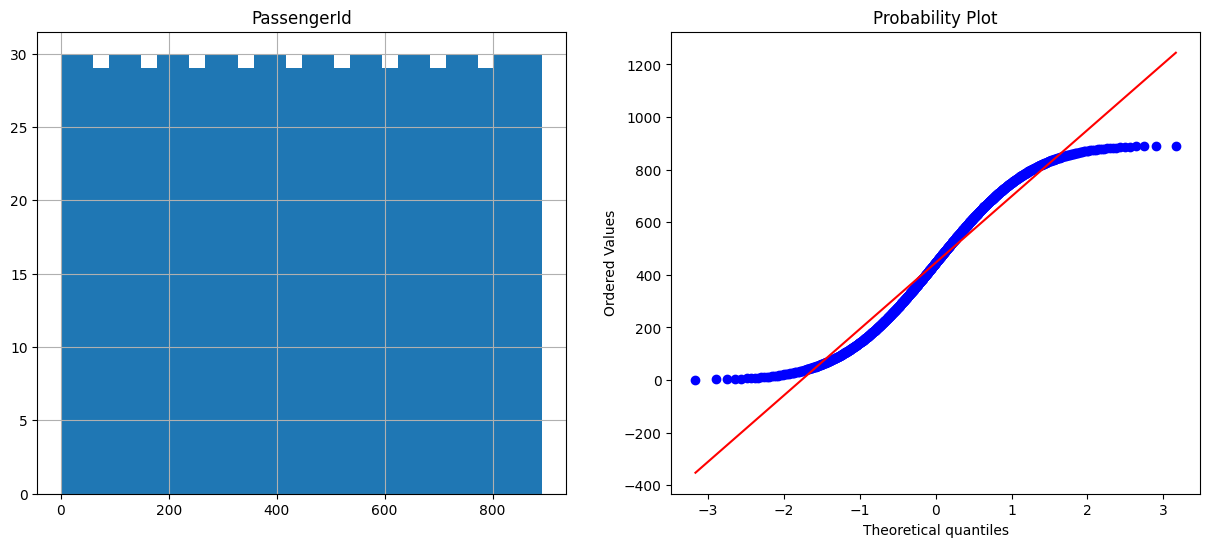

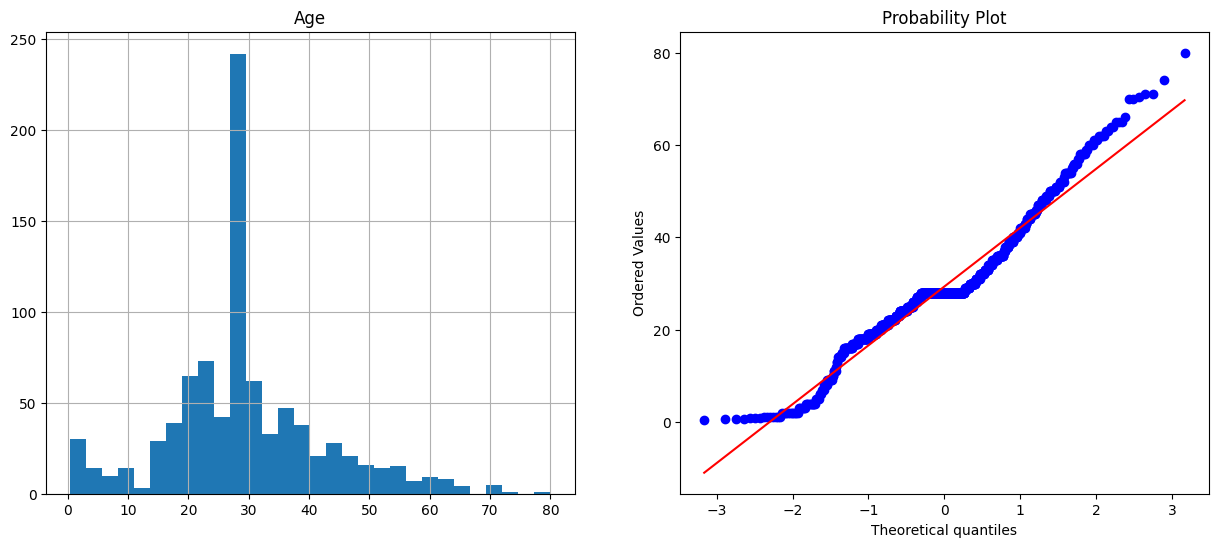

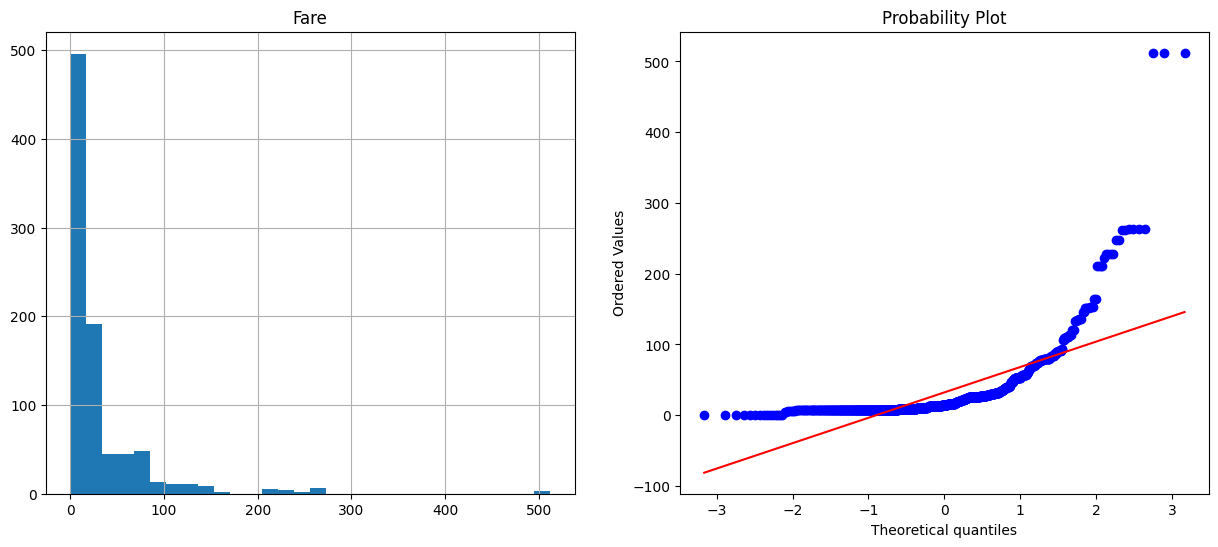

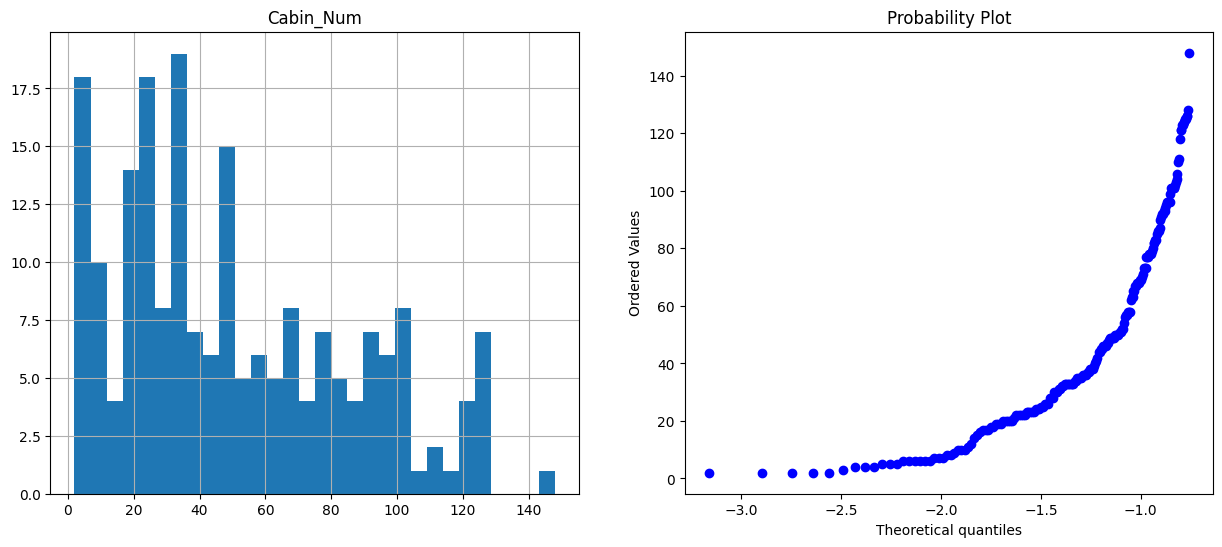

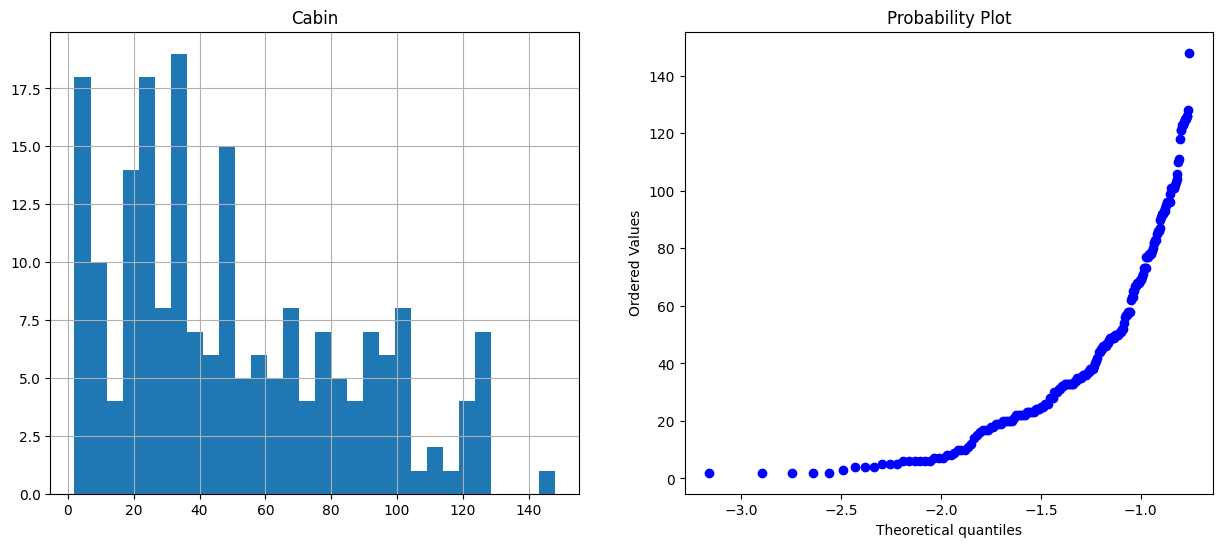

In [11]:
for col in continues_col:
    fn.plot_density_variable(data, col) 

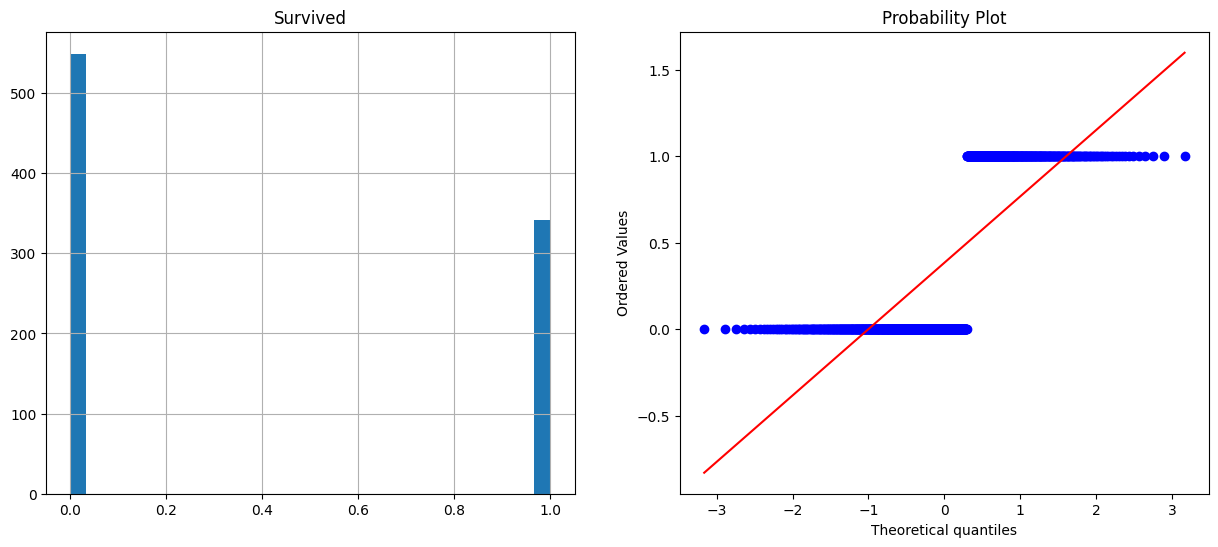

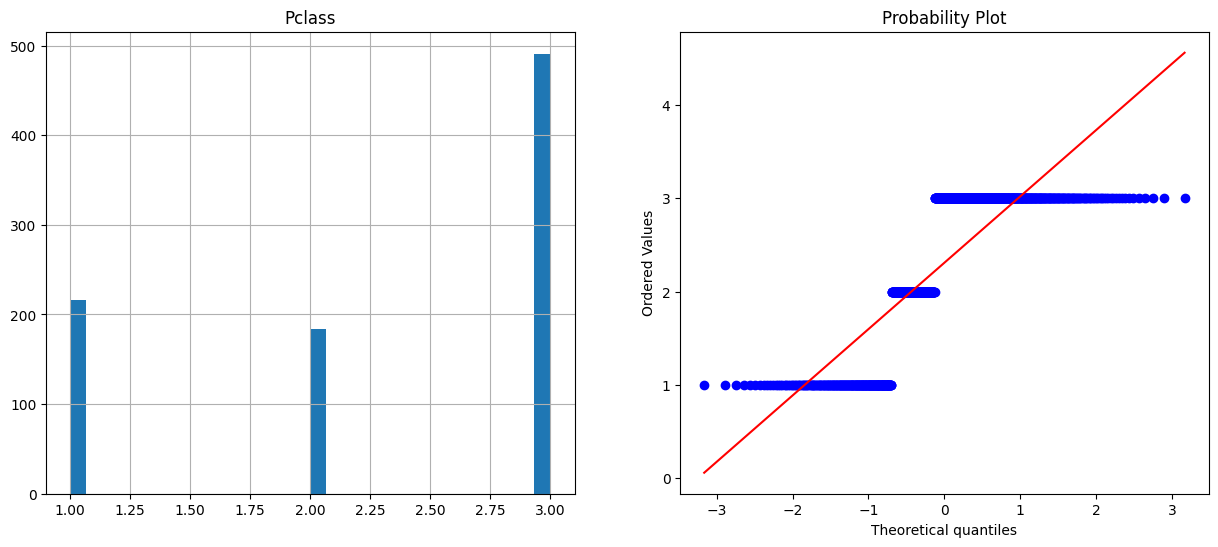

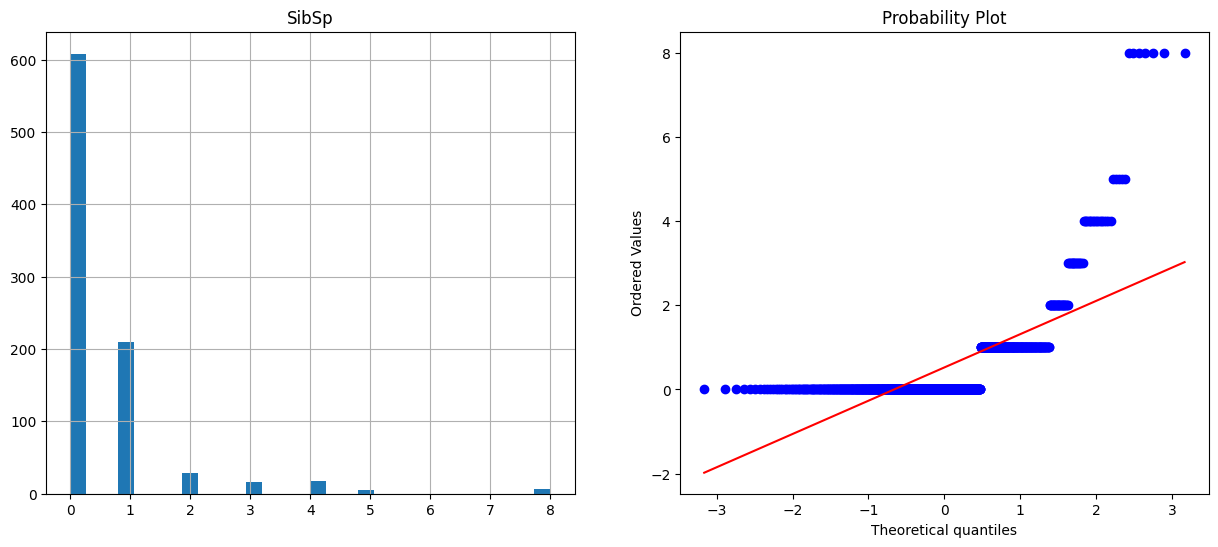

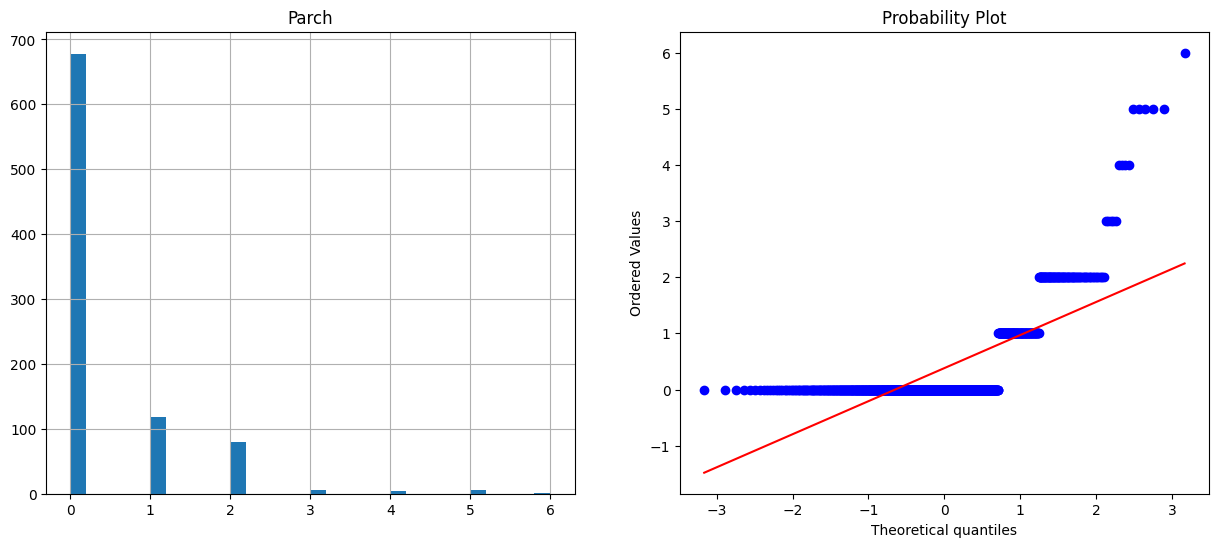

In [12]:
for col in discr_cols:
    fn.plot_density_variable(data, col) 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Survived'], axis=1),
    data['Survived'],
    test_size=0.3,
    random_state=2022)

In [14]:
X_train.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Cabin_Num      485
Cabin_Cat      481
Cabin          485
dtype: int64

Preparacion de Variables

In [15]:
#imputación de variables categóricas
CATEGORICAL_IMPUTER = ['Embarked','Cabin_Cat']

#Variables que eliminaremos
DROP_FEATURES = ['Name', 'Ticket', 'Cabin','PassengerId','Cabin_Cat','Cabin_Num']

#Variables para transfomraicón logarítmica
NUMERICAL_LOG_VARS = ["Age", "Fare", "Cabin"]

#Variables para codificación por frecuencia (no ordinal)
CATEGORICAL_VARS = ['Sex', 'Embarked', 'Cabin_Cat']

#Variables a utilzar en el entrenamiento
FEATURES = [
    'PassengerId',
    'Pclass',	
    'Name',	
    'Sex',	
    'Age',	
    'SibSp',	
    'Parch',
    'Ticket', 
    'Fare', 
    'Embarked',
    'Cabin_Num',
    'Cabin_Cat',
    'Cabin',

]

Preparacion Pipeline

In [16]:
proyecto_pipeline_GBC = Pipeline([

    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1, variables=NUMERICAL_LOG_VARS)),
    

    ('imputer_cat',
     mdi.CategoricalImputer(variables=CATEGORICAL_IMPUTER)),

   
    ('encoder_rare_label', ce.RareLabelEncoder(
        tol=0.01,
        n_categories=2,
        variables=CATEGORICAL_IMPUTER,
    )),
    
    ('categorical_encoder', ce.OrdinalEncoder(
        encoding_method='ordered',
        variables=CATEGORICAL_VARS,
    )),

    ('drop_time_features',
        DropFeatures(features_to_drop=DROP_FEATURES)
    ),

    ('gbm', GradientBoostingClassifier(random_state=2022))

])

In [17]:
proyecto_pipeline_GBC.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 ArbitraryNumberImputer(arbitrary_number=-1,
                                        variables=['Age', 'Fare', 'Cabin'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['Embarked', 'Cabin_Cat'])),
                ('encoder_rare_label',
                 RareLabelEncoder(n_categories=2, tol=0.01,
                                  variables=['Embarked', 'Cabin_Cat'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['Sex', 'Embarked', 'Cabin_Cat'])),
                ('drop_time_features',
                 DropFeatures(features_to_drop=['Name', 'Ticket', 'Cabin',
                                                'PassengerId', 'Cabin_Cat',
                                                'Cabin_Num'])),
                ('gbm', GradientBoostingClassifier(random_state=2022))])

In [18]:
X_test = X_test[FEATURES]
preds_GBC = proyecto_pipeline_GBC.predict(X_test)
preds_GBC

array([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=int64)

In [19]:
X_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Cabin_Num,Cabin_Cat,Cabin
770,771,3,"Lievens, Mr. Rene Aime",male,24.0,0,0,345781,9.5000,S,NaN,NaN,NaN
178,179,2,"Hale, Mr. Reginald",male,30.0,0,0,250653,13.0000,S,NaN,NaN,NaN
786,787,3,"Sjoblom, Miss. Anna Sofia",female,18.0,0,0,3101265,7.4958,S,NaN,NaN,NaN
159,160,3,"Sage, Master. Thomas Henry",male,28.0,8,2,CA. 2343,69.5500,S,NaN,NaN,NaN
656,657,3,"Radeff, Mr. Alexander",male,28.0,0,0,349223,7.8958,S,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
693,694,3,"Saad, Mr. Khalil",male,25.0,0,0,2672,7.2250,C,NaN,NaN,NaN
79,80,3,"Dowdell, Miss. Elizabeth",female,30.0,0,0,364516,12.4750,S,NaN,NaN,NaN
71,72,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9000,S,NaN,NaN,NaN
503,504,3,"Laitinen, Miss. Kristina Sofia",female,37.0,0,0,4135,9.5875,S,NaN,NaN,NaN


In [20]:
rmseTest_GBC = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(preds_GBC)))
rmseTest_GBC

0.711878564639504

In [21]:
joblib.dump(proyecto_pipeline_GBC, 'proyecto_pipeline_GBC.pkl')
joblib.dump(FEATURES, 'FEATURES.pkl')

['FEATURES.pkl']

In [22]:
proyecto_pipeline_LR = Pipeline([

    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1, variables=NUMERICAL_LOG_VARS)),
    

    ('imputer_cat',
     mdi.CategoricalImputer(variables=CATEGORICAL_IMPUTER)),

   
    ('encoder_rare_label', ce.RareLabelEncoder(
        tol=0.01,
        n_categories=2,
        variables=CATEGORICAL_IMPUTER,
    )),
    
    ('categorical_encoder', ce.OrdinalEncoder(
        encoding_method='ordered',
        variables=CATEGORICAL_VARS,
    )),

    ('drop_time_features',
        DropFeatures(features_to_drop=DROP_FEATURES)
    ),

    ('lr', LogisticRegression())

])

In [23]:
proyecto_pipeline_LR.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 ArbitraryNumberImputer(arbitrary_number=-1,
                                        variables=['Age', 'Fare', 'Cabin'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['Embarked', 'Cabin_Cat'])),
                ('encoder_rare_label',
                 RareLabelEncoder(n_categories=2, tol=0.01,
                                  variables=['Embarked', 'Cabin_Cat'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['Sex', 'Embarked', 'Cabin_Cat'])),
                ('drop_time_features',
                 DropFeatures(features_to_drop=['Name', 'Ticket', 'Cabin',
                                                'PassengerId', 'Cabin_Cat',
                                                'Cabin_Num'])),
                ('lr', LogisticRegression())])

In [24]:
preds_LR = proyecto_pipeline_LR.predict(X_test)
preds_LR


array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0], dtype=int64)

In [25]:
rmseTest_rl = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(preds_LR)))
rmseTest_rl

0.72718953270785

In [26]:
joblib.dump(proyecto_pipeline_LR, 'proyecto_pipeline_LR.pkl')

['proyecto_pipeline_LR.pkl']

In [27]:
proyecto_pipeline_RF = Pipeline([

    ('imputer_num',
     mdi.ArbitraryNumberImputer(arbitrary_number=-1, variables=NUMERICAL_LOG_VARS)),
    

    ('imputer_cat',
     mdi.CategoricalImputer(variables=CATEGORICAL_IMPUTER)),

   
    ('encoder_rare_label', ce.RareLabelEncoder(
        tol=0.01,
        n_categories=2,
        variables=CATEGORICAL_IMPUTER,
    )),
    
    ('categorical_encoder', ce.OrdinalEncoder(
        encoding_method='ordered',
        variables=CATEGORICAL_VARS,
    )),

    ('drop_time_features',
        DropFeatures(features_to_drop=DROP_FEATURES)
    ),

    ('rf', RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),)

])

In [28]:
proyecto_pipeline_RF.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 ArbitraryNumberImputer(arbitrary_number=-1,
                                        variables=['Age', 'Fare', 'Cabin'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['Embarked', 'Cabin_Cat'])),
                ('encoder_rare_label',
                 RareLabelEncoder(n_categories=2, tol=0.01,
                                  variables=['Embarked', 'Cabin_Cat'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['Sex', 'Embarked', 'Cabin_Cat'])),
                ('drop_time_features',
                 DropFeatures(features_to_drop=['Name', 'Ticket', 'Cabin',
                                                'PassengerId', 'Cabin_Cat',
                                                'Cabin_Num'])),
                ('rf',
                 RandomForestClassifier(max_depth=5, max_features=1,
                                        n_estimators=10))])

In [29]:
preds_rf = proyecto_pipeline_RF.predict(X_test)
preds_rf

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0], dtype=int64)

In [30]:
rmseTest_rf = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(preds_rf)))
rmseTest_rf

0.7924364214685209

In [31]:
joblib.dump(proyecto_pipeline_RF, 'proyecto_pipeline_RF.pkl')

['proyecto_pipeline_RF.pkl']